In [4]:
#Load libraries
import os
import numpy as np
import torch
import glob
import torch.nn as nn
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.autograd import Variable
import torchvision
import pathlib

In [5]:
# Define your transformation
transformer = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

In [6]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import os

# Path for the main dataset directory
dataset_path = r"E:\g42(cattle-proj)\cattle_final_dataset"

# Define a custom dataset class
class CustomDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data = torchvision.datasets.ImageFolder(data_dir, transform=transform)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

# Create the custom datasets
train_dataset = CustomDataset(os.path.join(dataset_path, 'train'), transform=transformer)
test_dataset = CustomDataset(os.path.join(dataset_path, 'test'), transform=transformer)

# Create data loaders for training and testing
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [7]:
#categories
root=pathlib.Path(os.path.join(dataset_path, 'train'))
classes=sorted([j.name.split('/')[-1] for j in root.iterdir()])

print(classes)
print(len(classes))

['050', '054_muzzle', '100', '150_muzzle', '151_muzzle', '152_muzzle', '153_muzzle', '154_muzzle', '155_muzzle', '156_muzzle', '157_muzzle', '158_muzzle', '159_muzzle', '160_muzzle', '161_muzzle', '162_muzzle', '163_muzzle', '164_muzzle', '165_muzzle', '166_muzzle', '167_muzzle', '168_muzzle', '169_muzzle', '170_muzzle', '171_muzzle', '172_muzzle', '173_muzzle', '174_muzzle', '175_muzzle', '176_muzzle', '177_muzzle', '178_muzzle', '179_muzzle', '180_muzzle', '181_muzzle', '182_muzzle', '183_muzzle', '184_muzzle', '185_muzzle', '186_muzzle', '187_muzzle', '188_muzzle', '189_muzzle', '190_muzzle', '191_muzzle', '192_muzzle', '193_muzzle', '194_muzzle', '195_muzzle', '196_muzzle', '197_muzzle', '198_muzzle', '199_muzzle', '200_muzzle', '201_muzzle', '204_muzzle', '205_muzzle', '206_muzzle', '207_muzzle', '208_muzzle', '209_muzzle', '210_muzzle', '211_muzzle', '212_muzzle', '213_muzzle', '214_muzzle', '215_muzzle', '216_muzzle', '217_muzzle', '218_muzzle', '220_muzzle', '221_muzzle', '222_

In [8]:
#checking for device
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [9]:
# Define your model architecture
class ConvNet(nn.Module):
    def __init__(self, num_classes):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=12, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(num_features=12)
        self.relu1 = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(in_channels=12, out_channels=20, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.conv3 = nn.Conv2d(in_channels=20, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(num_features=32)
        self.relu3 = nn.ReLU()
        self.fc = nn.Linear(in_features=75 * 75 * 32, out_features=num_classes)

    def forward(self, input):
        output = self.conv1(input)
        output = self.bn1(output)
        output = self.relu1(output)
        output = self.pool(output)
        output = self.conv2(output)
        output = self.relu2(output)
        output = self.conv3(output)
        output = self.bn3(output)
        output = self.relu3(output)
        output = output.view(-1, 32 * 75 * 75)
        output = self.fc(output)
        return output

In [10]:
# to train the model incrementally i.e fine-tuning


# Define your transformation
transformer = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

# Path to the existing model
model_path = 'cattle_aadhar_copy.model'

# Path for the new data
new_data_path = r"E:\g42(cattle-proj)\new_added"

# Load the existing model
model = ConvNet(num_classes=len(classes)).to(device)
model.load_state_dict(torch.load(model_path))

# Update the model's architecture for the combined dataset (146 old IDs + 1 new ID)
combined_num_classes = len(classes) +1  # 146 old cattle IDs + 1 new cattle ID (250)
model.fc = nn.Linear(in_features=75 * 75 * 32, out_features=combined_num_classes)

# Define the optimizer and loss function
optimizer = Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
loss_function = nn.CrossEntropyLoss()

In [10]:
# for adding new registration


# Combine the old and new datasets using a custom dataset class
class CombinedDataset(Dataset):
    def __init__(self, dataset1, dataset2):
        self.dataset1 = dataset1
        self.dataset2 = dataset2

    def __len__(self):
        return len(self.dataset1) + len(self.dataset2)

    def __getitem__(self, idx):
        if idx < len(self.dataset1):
            return self.dataset1[idx]
        else:
            return self.dataset2[idx - len(self.dataset1)]
        
new_data = CustomDataset(os.path.join(dataset_path, new_data_path), transform=transformer)

# Create the combined dataset
combined_dataset = CombinedDataset(train_dataset, new_data)
combined_loader = DataLoader(combined_dataset, batch_size=64, shuffle=True)

# Fine-tune the model on the combined dataset
model.train()

for epoch in range(10):  # Adjust the number of fine-tuning epochs
    train_accuracy = 0.0
    train_loss = 0.0

    for i, (images, labels) in enumerate(combined_loader):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)
        _, prediction = torch.max(outputs.data, 1)
        train_accuracy += int(torch.sum(prediction == labels.data))

    train_accuracy = train_accuracy / len(combined_dataset)
    train_loss = train_loss / len(combined_dataset)

    print(f'Fine-Tuning Epoch: {epoch}, Train Loss: {train_loss}, Train Accuracy: {train_accuracy}')

# Save the updated model
torch.save(model.state_dict(), 'cattle_aadhar_updated.model')


Fine-Tuning Epoch: 0, Train Loss: 3.6242195672341286, Train Accuracy: 0.3459983831851253
Fine-Tuning Epoch: 1, Train Loss: 0.4812027011894852, Train Accuracy: 0.8924818108326596
Fine-Tuning Epoch: 2, Train Loss: 0.16370826658454746, Train Accuracy: 0.9563459983831851
Fine-Tuning Epoch: 3, Train Loss: 0.07541501852732661, Train Accuracy: 0.9830234438156831
Fine-Tuning Epoch: 4, Train Loss: 0.03200588416456483, Train Accuracy: 0.9927243330638642
Fine-Tuning Epoch: 5, Train Loss: 0.01939505157222792, Train Accuracy: 0.9959579628132579
Fine-Tuning Epoch: 6, Train Loss: 0.008309259356835987, Train Accuracy: 0.9983831851253031
Fine-Tuning Epoch: 7, Train Loss: 0.00902334265204797, Train Accuracy: 0.9983831851253031
Fine-Tuning Epoch: 8, Train Loss: 0.0036686619816358496, Train Accuracy: 0.9991915925626516
Fine-Tuning Epoch: 9, Train Loss: 0.001882635134378811, Train Accuracy: 1.0


In [11]:
# after fine-tuning to remove the old model which is named as cattle_aadhar_copy.model and rename the new model cattle_aadhar_updated.model as cattle_aadhar_copy.model


import os

# Delete the old model
old_model_path = 'cattle_aadhar_copy.model'
if os.path.exists(old_model_path):
    os.remove(old_model_path)
    print(f"Deleted old model: {old_model_path}")

# Rename the updated model
updated_model_path = 'cattle_aadhar_updated.model'
new_model_path = 'cattle_aadhar_copy.model'
os.rename(updated_model_path, new_model_path)
print(f"Renamed updated model to: {new_model_path}")


Deleted old model: cattle_aadhar_copy.model
Renamed updated model to: cattle_aadhar_copy.model


In [13]:
# to check what folders are present in new_added folder

import os

directory_path = r"E:\g42(cattle-proj)\new_added"  # Replace with the path to your directory

# Get a list of all items (files and folders) in the directory
items = os.listdir(directory_path)

# Filter the items to get only the folders (directories)
folders = [item for item in items if os.path.isdir(os.path.join(directory_path, item))]

# Print the list of folders
for folder in folders:
    f=folder
print(f)

cattle_0100


In [18]:
# to move the newly trained cattle to already trained cattles

import shutil

source_path = r"E:\g42(cattle-proj)\new_added"

source_folder = os.path.join(source_path,f)  # Replace with the path to the source folder
destination_folder = r"E:\g42(cattle-proj)\cattle_final_dataset\train"  # Replace with the path to the destination folder

# Move the '250_muzzle' folder to the destination folder
shutil.move(source_folder, destination_folder)


'E:\\g42(cattle-proj)\\cattle_final_dataset\\train\\cattle_0100'

In [9]:
#categories
root=pathlib.Path(os.path.join(dataset_path, 'train'))
classes=sorted([j.name.split('/')[-1] for j in root.iterdir()])

print(classes)
print(len(classes))

['050', '054_muzzle', '100', '150_muzzle', '151_muzzle', '152_muzzle', '153_muzzle', '154_muzzle', '155_muzzle', '156_muzzle', '157_muzzle', '158_muzzle', '159_muzzle', '160_muzzle', '161_muzzle', '162_muzzle', '163_muzzle', '164_muzzle', '165_muzzle', '166_muzzle', '167_muzzle', '168_muzzle', '169_muzzle', '170_muzzle', '171_muzzle', '172_muzzle', '173_muzzle', '174_muzzle', '175_muzzle', '176_muzzle', '177_muzzle', '178_muzzle', '179_muzzle', '180_muzzle', '181_muzzle', '182_muzzle', '183_muzzle', '184_muzzle', '185_muzzle', '186_muzzle', '187_muzzle', '188_muzzle', '189_muzzle', '190_muzzle', '191_muzzle', '192_muzzle', '193_muzzle', '194_muzzle', '195_muzzle', '196_muzzle', '197_muzzle', '198_muzzle', '199_muzzle', '200_muzzle', '201_muzzle', '204_muzzle', '205_muzzle', '206_muzzle', '207_muzzle', '208_muzzle', '209_muzzle', '210_muzzle', '211_muzzle', '212_muzzle', '213_muzzle', '214_muzzle', '215_muzzle', '216_muzzle', '217_muzzle', '218_muzzle', '220_muzzle', '221_muzzle', '222_

In [10]:
import torch

# Create an instance of your model
model = ConvNet(num_classes=len(classes))  # Replace with your actual model class and configuration

# Load the saved model weights
model.load_state_dict(torch.load('cattle_aadhar_copy.model'))

# Set the model in evaluation mode (important if you're using dropout or batch normalization)
model.eval()

ConvNet(
  (conv1): Conv2d(3, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(12, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (conv3): Conv2d(20, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (fc): Linear(in_features=180000, out_features=150, bias=True)
)

In [9]:
import torch

# Assuming tensor1 and tensor2 are your two tensors
tensor1 = torch.tensor([[  6.5371, -19.3360, -19.0776, -14.4396, -16.8002, -22.5280,  -7.6527,
         -17.9633, -16.5074, -14.0633, -18.8894, -25.7352, -25.2688, -12.9061,
         -13.2991, -18.6366, -15.0103, -24.0876, -21.3251, -22.3753, -18.7472,
         -20.5405, -16.4260, -16.0588, -24.2321,  -7.4647, -17.2443, -18.1174,
          -6.5236, -13.5583,  -4.8678, -14.8383, -12.2263, -15.8481, -22.3048,
         -11.0926, -18.2959,  -6.2079, -23.2852, -16.9684, -30.2456, -21.4383,
         -20.7051, -14.9434, -20.9345, -20.2689, -24.2631,  -2.7388, -24.5607,
          -5.7049, -10.7160, -10.1493, -13.5380, -13.0908, -15.1456, -11.6808,
          -8.5991, -18.8080, -21.1398, -20.2393, -10.5309, -18.8499, -21.3764,
         -19.8163,  -5.9118, -27.1839, -10.5513, -14.9402, -21.9184, -20.0329,
         -22.2188, -19.6090, -22.1819, -13.2962, -21.6181, -10.5572, -12.7969,
         -17.0915,  -9.2038, -17.3579, -14.4668, -17.7998, -15.8298, -20.7652,
          -5.7256,  -4.8463, -14.7671, -15.4504, -21.5040, -12.9719,  -2.6970,
         -19.7600, -19.2650, -13.5190, -21.9013, -15.4935, -18.7133,  -4.1327,
         -11.0829, -10.8150, -17.7478, -20.1107, -13.3786, -19.7994, -16.3275,
          -7.4085, -13.2405, -14.3043, -12.3779, -19.9927, -22.0098, -14.3770,
          -5.3350, -18.6119,  -7.3580, -10.5836, -22.4312, -18.6632, -17.0329,
         -10.6835, -25.3300, -27.0039, -16.6436,  -8.7019, -10.4306, -15.7599,
         -23.0024, -13.1891, -14.7553, -16.1825, -29.4267, -21.9308, -12.9502,
         -10.3692, -12.3828, -18.2302, -16.5014, -22.5469, -20.5992, -19.9890,
         -12.0633, -14.3399, -20.1560, -12.3453,  -9.5356,  -0.4668, -44.5037]])

tensor2 = torch.tensor([[  9.5424, -23.6340, -29.0779, -24.3913, -25.1843, -31.2242, -15.2095,
         -22.2791, -28.1671, -21.9873, -30.5131, -36.7235, -32.1511, -20.7674,
         -16.7840, -25.5771, -20.5994, -38.3753, -15.8138, -32.1284, -28.4576,
         -16.1448, -27.9621, -21.5243, -28.2380,  -4.5522, -20.0330, -26.3655,
         -15.0433, -18.7214, -15.4056, -16.2614, -13.6040, -21.8995, -27.2476,
         -12.6512, -26.8652,  -8.4423, -29.6405, -23.4859, -33.6291, -28.0008,
         -27.8274, -28.4335, -23.8277, -18.0989, -27.3182, -16.7000, -29.8366,
         -15.2044, -16.0721, -18.3276, -32.3414, -20.0376, -27.0423, -22.2444,
         -24.4003, -16.8287, -26.7648, -33.3757,  -4.9305, -15.7985, -15.6606,
         -25.4034, -16.2415, -38.1160, -11.5713, -15.6831, -34.3122, -31.2038,
         -29.0544, -22.1235, -33.5313, -18.9547, -33.8798, -20.0551, -21.3525,
         -22.6087, -11.3375, -27.7518, -28.0023, -21.3714, -21.5219, -32.4895,
          -9.5645,  -5.6787, -19.5105, -22.5781, -24.9135, -32.8573, -10.2477,
         -23.8981, -24.1108, -12.5385, -16.2015, -15.7753, -23.5596,  -5.4514,
         -15.2890, -12.7940, -30.9049, -31.1625, -26.3564, -35.4481, -22.6666,
          -9.8406, -23.8854, -21.4597, -21.2447, -27.8674, -29.4481, -26.5718,
         -16.3144, -24.2873, -17.0973, -21.7754, -29.5936, -25.6418, -24.4927,
         -19.6083, -31.7156, -34.0437, -26.5027, -16.6187, -19.2571, -23.9305,
         -30.0099, -26.0544, -29.3201, -23.2846, -35.4558, -32.6372, -18.0226,
         -28.2430, -28.3306, -22.8457, -22.6480, -31.5130, -31.9289, -30.4340,
         -20.6324, -20.8454, -31.4170, -16.9806,  -9.1389,  -5.7061, -62.6420]])

# tensor3 = torch.tensor([[  6.6506, -19.5557, -24.4939, -19.8511, -26.3727, -29.8079, -13.8146,
#          -19.8867, -28.0225, -16.1575, -26.1401, -35.0539, -31.0443, -15.5158,
#          -11.5478, -22.4979, -15.9906, -31.2238, -20.0162, -24.4720, -25.3488,
#          -19.7117, -22.6284, -18.2487, -29.1556,  -7.8666, -23.8772, -23.7595,
#          -12.6846, -16.9903, -13.1534, -17.7321, -14.4833, -20.1446, -22.1767,
#          -12.2012, -25.5303,  -8.1958, -28.7319, -22.1111, -34.1862, -23.2008,
#          -21.3176, -24.8225, -20.3983, -20.6235, -25.7248,  -9.7157, -28.2223,
#           -9.8268, -15.0869, -16.4228, -25.1706, -18.7951, -20.8164, -20.9963,
#          -14.8422, -18.5897, -27.2247, -28.9047, -12.0006, -18.9858, -19.9130,
#          -24.3318, -10.0797, -32.3742,  -7.2027, -16.0642, -29.0359, -27.2658,
#          -25.1641, -16.0646, -25.2300, -19.1700, -25.6453, -19.9797, -20.8379,
#          -16.2871, -11.1865, -24.2838, -22.9473, -24.4453, -19.1783, -26.3323,
#           -5.7410,  -7.0940, -17.0841, -21.4742, -22.4471, -22.2434,  -6.8170,
#          -21.8467, -23.1927, -13.0653, -18.5982, -17.4860, -24.4700,  -5.7101,
#          -10.6467, -15.1693, -22.1948, -24.9848, -17.0153, -31.6902, -20.0562,
#          -10.1024, -20.4604, -19.8150, -20.5040, -28.7850, -30.1360, -22.8967,
#          -12.0286, -25.2543,  -9.8078, -14.3832, -25.3405, -25.1746, -21.3535,
#          -14.4332, -27.2321, -33.0637, -23.6632, -17.6941, -19.1897, -17.2949,
#          -28.7850, -18.8521, -23.2632, -19.8440, -33.8522, -26.3803, -14.0426,
#          -19.0468, -22.1209, -21.0297, -17.8499, -29.9843, -27.2982, -21.0777,
#          -15.8584, -16.4656, -29.2091, -15.5814,  -9.6041,  -3.8786, -57.9118]])

# tensor4 = torch.tensor([[ -3.4824, -10.8680,  -8.1529,   5.4700, -11.6167, -17.2581, -10.9423,
#          -12.9003, -10.1830, -12.9856,  -9.6973, -28.6968, -24.4891, -10.1501,
#          -14.8255, -11.5762,  -8.8104, -11.5376, -25.0054, -14.5749, -16.0652,
#          -17.5483, -14.1089, -12.6145, -11.3810, -16.7445, -25.0733, -12.6694,
#          -11.9169, -15.8379, -10.8573, -21.8769, -18.8176, -21.1937, -13.4471,
#          -19.0147,  -8.0860, -16.4221, -14.8214, -13.9633, -27.5173, -15.7050,
#           -7.1690, -17.3499, -16.4446, -15.7085, -15.6009,  -8.1334,  -9.7322,
#           -7.3527, -19.2011, -11.4397,  -9.4702, -13.8731, -17.1898,  -9.3663,
#          -10.4188, -15.9549, -14.1349, -14.2393, -15.6420,  -9.8525, -17.2397,
#          -18.5343,  -6.2280, -18.1943, -12.3533, -12.8807, -18.0223, -23.3994,
#          -17.5456,  -8.2631, -15.1875,  -8.4856, -20.1222, -15.2967, -14.8282,
#           -7.8134, -12.3526, -17.2257, -17.8997, -10.4578, -17.3465,  -9.4866,
#          -18.0180, -19.3010, -19.5958, -14.7932, -12.2732, -12.9189,  -5.4484,
#           -6.3284, -12.7052, -13.9353, -15.6860, -22.2755, -14.8091,  -8.7975,
#          -10.0313, -22.6271, -20.6745, -13.3297, -11.3387, -18.8216, -15.5083,
#           -6.1811,  -7.1955, -20.7856, -14.9561, -14.6680, -16.2311, -16.2188,
#          -14.5527, -11.3940, -12.9701,  -8.7783, -11.0011,  -7.1113, -15.3198,
#           -8.4124, -12.8897, -11.7705,  -6.7462, -16.0557, -14.1750, -10.6590,
#          -21.2112, -12.2705, -13.9947,  -9.9216,  -9.9698, -12.3600,  -9.9378,
#          -14.3154, -13.8376,  -8.2310,  -9.6981, -18.8056, -30.9564, -18.6544,
#           -5.7622, -10.9579, -11.6333,  -7.4965,  -9.7484, -13.2656, -46.1898]])

# # # Calculate the Euclidean distance
# # distance12 = torch.norm(tensor1 - tensor2)
# # distance13 = torch.norm(tensor1 - tensor3)
# # distance23 = torch.norm(tensor2 - tensor3)
# # distance14 = torch.norm(tensor1 - tensor4)
# # distance24 = torch.norm(tensor2 - tensor4)
# # distance34 = torch.norm(tensor3 - tensor4)

# # print(distance12)
# # print(distance13)
# # print(distance23)
# # print(distance14)
# # print(distance24)
# # print(distance34)


# import torch.nn.functional as F

# similarity12 = F.cosine_similarity(tensor1, tensor2)
# similarity13 = F.cosine_similarity(tensor1, tensor3)
# similarity23 = F.cosine_similarity(tensor2, tensor3)
# similarity14 = F.cosine_similarity(tensor1, tensor4)
# similarity24 = F.cosine_similarity(tensor2, tensor4)
# similarity34 = F.cosine_similarity(tensor3, tensor4)


# # Print the distance
# print(similarity12)
# print(similarity12)
# print(similarity23)
# print(similarity14)
# print(similarity24)
# print(similarity34)


In [10]:
# Convert tensors to NumPy arrays
tensor1_np = tensor1.numpy()
tensor2_np = tensor2.numpy()

# Flatten the NumPy arrays into 1D arrays
tensor1_flat = tensor1_np.flatten()
tensor2_flat = tensor2_np.flatten()

# Calculate the correlation coefficient using NumPy
correlation = np.corrcoef(tensor1_flat, tensor2_flat)[0, 1]

print(f"Correlation Coefficient: {correlation}")

Correlation Coefficient: 0.8143159906393567


In [54]:
from scipy.stats import pearsonr

corr_coefficient, _ = pearsonr(tensor1_flat, tensor2_flat)

print(corr_coefficient)

0.8143159906393567


In [11]:
#categories
root=pathlib.Path(os.path.join(dataset_path, 'train'))
classes=sorted([j.name.split('/')[-1] for j in root.iterdir()])

print(classes)
print(len(classes))

['050', '054_muzzle', '100', '150_muzzle', '151_muzzle', '152_muzzle', '153_muzzle', '154_muzzle', '155_muzzle', '156_muzzle', '157_muzzle', '158_muzzle', '159_muzzle', '160_muzzle', '161_muzzle', '162_muzzle', '163_muzzle', '164_muzzle', '165_muzzle', '166_muzzle', '167_muzzle', '168_muzzle', '169_muzzle', '170_muzzle', '171_muzzle', '172_muzzle', '173_muzzle', '174_muzzle', '175_muzzle', '176_muzzle', '177_muzzle', '178_muzzle', '179_muzzle', '180_muzzle', '181_muzzle', '182_muzzle', '183_muzzle', '184_muzzle', '185_muzzle', '186_muzzle', '187_muzzle', '188_muzzle', '189_muzzle', '190_muzzle', '191_muzzle', '192_muzzle', '193_muzzle', '194_muzzle', '195_muzzle', '196_muzzle', '197_muzzle', '198_muzzle', '199_muzzle', '200_muzzle', '201_muzzle', '204_muzzle', '205_muzzle', '206_muzzle', '207_muzzle', '208_muzzle', '209_muzzle', '210_muzzle', '211_muzzle', '212_muzzle', '213_muzzle', '214_muzzle', '215_muzzle', '216_muzzle', '217_muzzle', '218_muzzle', '220_muzzle', '221_muzzle', '222_

In [16]:
# with cosine similarity

import torch
from torchvision import transforms
from PIL import Image

# Define the transformation for input images (should match the one used during training)
transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

# Load the trained model
model_path = 'cattle_aadhar_copy.model'
model = ConvNet(num_classes=len(classes))  # Update with the correct number of classes
model.load_state_dict(torch.load(model_path))
model.eval()  # Set the model to evaluation mode

# Load and preprocess the input image
input_image_path = r"E:\g42(cattle-proj)\cattle_final_dataset\train\050\IMG_0354.JPG"  # Update with the path to your image
input_image = Image.open(input_image_path)
# print("input_image",input_image)
input_tensor = transform(input_image)
# print("input_tensor",input_tensor)
input_tensor = input_tensor.unsqueeze(0)  # Add a batch dimension
# print("input_tensor",input_tensor)

# Make predictions
with torch.no_grad():
    output = model(input_tensor)

# print(output)

input_image = output.numpy()

print(input_image)

tensor_input = torch.tensor(input_image)

print(torch.max(output),1)


[[ -3.0760465 -13.543716  -21.697273  -27.994904  -15.812916  -18.596022
  -27.340832  -17.331442  -24.639326  -19.293858  -20.90022   -21.371775
  -24.277346  -23.156113  -21.06816   -25.34511   -17.183884  -16.843763
  -20.146568  -16.959867  -26.378374  -18.26944   -23.350634  -19.127674
  -20.303585  -13.272857  -22.715874  -21.973923  -20.060728  -25.941135
  -25.804672  -16.15197   -22.771595  -26.067518  -25.195122  -26.612915
  -22.728075  -16.253622  -19.263865  -22.635155  -25.80381   -20.565277
  -15.7604065 -23.18114   -23.100761  -28.093851  -20.583414  -13.989737
  -20.109085  -18.731153  -22.78951   -16.3597    -21.896666  -20.072605
  -18.499426  -17.559978  -26.163397  -20.130264  -16.639267  -20.288473
  -23.297674  -16.211176  -20.773167  -24.937067  -22.814362  -18.193758
  -16.93564   -24.459476  -25.244648  -21.179562  -24.073046  -23.953375
  -20.6772    -18.370365  -22.57423   -25.81543   -25.272     -20.215816
  -22.838806  -23.806862  -24.068317  -31.860638  -

In [42]:
# to acccess each image present in each cattle id

b = False

from PIL import Image
import os

import torch
import torch.nn.functional as F

parent_directory = r"E:\g42\cattle_final_dataset\train"  # Replace with the path to your "cattle" directory

sl=[]
cl=[]

# Iterate through each subdirectory (representing different cattle)
for cattle_id in os.listdir(parent_directory):
    cattle_directory = os.path.join(parent_directory, cattle_id)

    # Ensure it's a directory
    if os.path.isdir(cattle_directory):
#         print(f"Accessing cattle ID: {cattle_id}")

        maxi=0

        # Iterate through image files in the cattle's directory
        for image_file in os.listdir(cattle_directory):
            if image_file.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp')):
                
                image_path = os.path.join(cattle_directory, image_file)
#               print(f"Processing image: {image_path}")
                    
                # to replace \ by \\
                    
                image_path='r'+image_path[0:]
                i = 0
                # print(image_path)
                while i < len(image_path):
                # print(image_path[i])
                    if image_path[i] == '\\':
                        i = i + 1
                        image_path = image_path[:i] + '\\' + image_path[i:]
                    i = i + 1
                image_path=image_path[1:]
#               print(image_path)
                    
                # Load and preprocess the input image
                input_image_path = image_path  # Update with the path to your image
                input_image = Image.open(input_image_path)
                input_tensor = transform(input_image)
                input_tensor = input_tensor.unsqueeze(0)  # Add a batch dimension

                # Make predictions
                with torch.no_grad():
                    output = model(input_tensor)
                    
                class_checker = output.numpy()
                    
                tensor_class = torch.tensor(class_checker)
                    
                similarity=F.cosine_similarity(tensor_input, tensor_class)
                
                if((similarity.item())>0.98 and (similarity.item())>maxi):
                    b=True
                    maxi=similarity.item()
#                     print(maxi)
#               print(class_checker)


#               print("prediction class is ",cattle_id)
        if(b): 
            b=False
            cl.append(cattle_id)
            sl.append(maxi)
                    # Here, you can perform any processing you need on the image



# Note: Replace the extensions in `endswith` with the image formats you want to process


# print(cl)   # to cheeck silimar classes
# print(sl)    # to cheeck silimarity of classes

if(len(sl)!=0):
    b=True
else:
    b=False

maximum=0

for i in sl:
    if(i>maximum):
        maximum=i
        
from IPython.display import Image

if(not b):
    print("cant find this registration")
else:
    # print(sl)
    print(maximum)
    ind=sl.index(maximum)
    print(ind)
    print("prediction class is ",cl[ind])
#     print_face_of_prediction=os.path.join("E:\g42\cattle_final_dataset_face",cl[ind])

#     folder_path =os.path.join("E:\g42\cattle_final_dataset_face",cl[ind])  # Replace with the path to your folder

# #     print(folder_path)


#     # Check if the folder exists
#     if os.path.exists(folder_path) and os.path.isdir(folder_path):
#         # List image files in the folder
#         image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.jpg', '.jpeg', '.png', '.gif', '.bmp', '.tiff', '.webp'))]

#         if not image_files:
#             print("No image files found in the folder.")
#         else:
#             # Display the first image (you can change the index to display a different image)
#             first_image_path = os.path.join(folder_path, image_files[0])
#             display(Image(filename=first_image_path,width=200))
#     else:
#         print("Folder not found.")

0.9919374585151672
24
prediction class is  331_muzzle


In [28]:
# with corelation factor

import torch
from torchvision import transforms
from PIL import Image

# Define the transformation for input images (should match the one used during training)
transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

# Load the trained model
model_path = 'cattle_aadhar_copy.model'
model = ConvNet(num_classes=len(classes))  # Update with the correct number of classes
model.load_state_dict(torch.load(model_path))
model.eval()  # Set the model to evaluation mode

# Load and preprocess the input image
input_image_path = r"E:\g42(cattle-proj)\cattle_final_dataset\train\100\cattle_0100_DSCF3858.jpg"  # Update with the path to your image
input_image = Image.open(input_image_path)
input_tensor = transform(input_image)
input_tensor = input_tensor.unsqueeze(0)  # Add a batch dimension

# Make predictions
with torch.no_grad():
    output = model(input_tensor)

# print(output)

print(torch.max(output))


input_image = output.numpy()

print(input_image)

corelation_input = input_image.flatten()


tensor(0.0901)
[[  0.09007281 -18.987139   -14.263393   -14.635631   -20.671247
  -14.127736   -18.497616    -9.6630125  -21.111933   -12.460126
  -18.504135   -16.069437   -18.588108   -14.969631   -17.207573
  -13.666051   -18.870665    -8.326452   -14.826114   -14.163173
  -21.566017   -16.976297   -18.412354   -15.749197   -16.740065
  -13.894605   -14.923884   -17.345812   -12.602642   -20.110603
  -20.3536     -16.932121   -11.877556   -16.822485   -13.847424
  -21.125364   -22.286541   -10.866188    -8.847357   -18.24114
  -10.622521   -16.91095    -11.038967   -21.731537   -12.896014
  -19.10845    -18.495222   -10.327918   -14.547873   -18.051805
  -20.013176   -18.006805   -19.741344   -18.039726   -18.351896
  -16.56077    -15.807679   -18.204533   -16.653322   -17.741373
  -16.442413   -15.12747    -16.428234   -19.377789   -18.7189
  -13.010399   -16.80783    -16.134068   -19.440184   -18.654125
  -19.246109   -20.223686   -16.054647   -21.13045    -14.915087
  -20.198168 

In [ ]:
# [[-24.591526   -23.713907   -25.043493   -24.884064   -19.702236
#   -28.316532   -28.120605   -23.47566    -24.809557   -22.478592
#   -19.729124   -29.711159   -22.502392   -19.29472    -18.927214
#   -18.325779   -18.981129   -24.979649   -23.150753   -16.884537
#   -25.180393   -14.393396   -23.738892   -15.062793   -26.275934
#   -20.05392    -20.31707    -21.223103   -25.108786   -20.036797
#   -19.637436   -18.220398   -19.863493   -17.087421   -26.798855
#   -24.907825   -29.382568   -13.014442   -29.46207    -24.61201
#   -22.093613   -21.100754   -20.221638   -26.32782    -21.73158
#   -17.080915   -28.19062    -28.337734   -21.101036   -25.065754
#   -23.68116    -24.03091    -23.965166   -20.090424   -30.40816
#   -23.222418   -25.159729   -15.956894   -24.772945   -23.373983
#   -16.272064   -11.00207      0.25346035 -21.549139   -21.046764
#   -21.656525   -22.920204   -18.845371   -26.723213   -27.889751
#   -31.160488   -19.340107   -27.909628   -21.361103   -28.346207
#   -22.184654   -24.36451    -24.393291   -16.228333   -24.229624
#   -20.554546   -26.087383   -24.233042   -25.078373   -14.847291
#   -18.780354   -22.279469   -22.153025   -24.364056   -23.496376
#   -22.65878    -27.541988   -23.175488   -17.499622   -24.784351
#   -17.18163    -20.490519   -29.56549    -20.35848    -20.086676
#   -20.622595   -29.126911   -22.569803   -21.834234   -19.174288
#   -24.996782   -20.175577   -28.280542   -29.547493   -26.909372
#   -30.341858   -26.77444    -24.629532   -27.76162    -25.64827
#   -24.289001   -24.80911    -24.130686   -20.000004   -22.874294
#   -28.086239   -26.242817   -23.71819    -28.184483   -25.981121
#   -24.42516    -23.305561   -20.256649   -22.325863   -27.811043
#   -26.618458   -24.690792   -23.698885   -21.19004    -18.785555
#   -27.07306    -27.662813   -22.276459   -29.571983   -24.014423
#   -21.55605    -25.193256   -18.93213    -30.866571   -14.955166
#   -20.755178   -25.798204   -17.904459  ]]


# [[-27.40831  -29.03247  -28.60876  -31.72595  -28.114134 -23.611439
#   -32.270416 -29.763973 -21.620298 -31.349503 -23.741474 -27.491066
#   -26.532928 -24.754578 -24.94793  -25.789469 -24.895695 -22.77759
#   -30.873322 -24.28236  -21.660666 -30.382221 -24.01861  -26.17168
#   -22.181614 -25.133202 -26.835394 -25.396784 -25.295168 -29.484713
#   -25.849731 -27.10204  -22.718142 -19.110304 -22.826374 -29.817127
#   -26.04857  -29.478802 -22.765827 -30.909676 -28.181263 -23.529873
#   -26.456047 -28.146673 -27.509647 -24.490343 -23.454128 -30.554243
#   -27.245975 -24.822014 -29.892023 -27.805384 -30.995422 -27.406055
#   -30.336658 -29.567339 -24.531876 -29.505665 -23.561718 -29.802277
#   -28.093948 -21.406345 -25.646019  -9.723192 -29.642963 -22.483974
#   -24.951754 -20.975647 -25.355515 -31.765884 -31.49701  -28.60651
#   -22.095198 -26.179989 -27.730988 -34.18228  -26.447607 -30.084312
#   -26.352097 -18.909353 -28.516438 -25.066536 -26.374645 -27.075756
#   -25.423986 -20.289877 -24.213844 -27.888245 -26.911911 -31.396996
#   -33.545403 -29.716934 -27.379072 -29.320114 -25.552734 -26.117609
#   -27.611803 -25.959671 -26.831627 -27.029158 -22.453913 -25.565296
#   -29.390419 -24.345879 -25.935192 -27.471966 -27.968056 -25.309414
#   -31.479109 -29.443039 -31.628439 -32.780846 -33.38173  -29.027424
#   -27.954082 -34.956596 -26.188541 -30.490982 -27.109455 -23.773964
#   -29.3471   -26.189812 -28.086731 -29.654652 -30.4995   -28.567362
#   -24.979956 -27.840345 -25.538542 -28.6153   -28.82595  -31.587723
#   -27.975653 -26.374722 -32.075138 -25.796593 -28.65703  -31.174232
#   -27.885067 -30.584396 -24.72358  -25.156971 -29.944778 -27.954815
#   -27.909002 -24.371307 -23.431616 -24.364395 -23.194689]]

In [29]:

# to acccess each image present in each cattle id

b = False

from PIL import Image
import os

import torch
import torch.nn.functional as F

parent_directory = r"E:\g42(cattle-proj)\cattle_final_dataset\train"  # Replace with the path to your "cattle" directory

sl=[]
cl=[]

# Iterate through each subdirectory (representing different cattle)
for cattle_id in os.listdir(parent_directory):
    cattle_directory = os.path.join(parent_directory, cattle_id)

    # Ensure it's a directory
    if os.path.isdir(cattle_directory):
#         print(f"Accessing cattle ID: {cattle_id}")

        maxi=0

        # Iterate through image files in the cattle's directory
        for image_file in os.listdir(cattle_directory):
            if image_file.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp')):
                
                image_path = os.path.join(cattle_directory, image_file)
#               print(f"Processing image: {image_path}")
                    
                # to replace \ by \\
                    
                image_path='r'+image_path[0:]
                i = 0
                # print(image_path)
                while i < len(image_path):
                # print(image_path[i])
                    if image_path[i] == '\\':
                        i = i + 1
                        image_path = image_path[:i] + '\\' + image_path[i:]
                    i = i + 1
                image_path=image_path[1:]
#               print(image_path)
                    
                # Load and preprocess the input image
                input_image_path = image_path  # Update with the path to your image
                input_image = Image.open(input_image_path)
                input_tensor = transform(input_image)
                input_tensor = input_tensor.unsqueeze(0)  # Add a batch dimension

                # Make predictions
                with torch.no_grad():
                    output = model(input_tensor)
                    
                class_checker = output.numpy()
                    
                corelation_class = class_checker.flatten()
                    
                similarity=np.corrcoef(corelation_input, corelation_class)[0, 1]
                
                if((similarity.item())>0.90 and (similarity.item())>maxi):
                    b=True
                    maxi=similarity.item()
#                     print(maxi)
#               print(class_checker)


#               print("prediction class is ",cattle_id)
        if(b): 
            b=False
            cl.append(cattle_id)
            sl.append(maxi)
                    # Here, you can perform any processing you need on the image



# Note: Replace the extensions in `endswith` with the image formats you want to process


print(cl)   # to cheeck silimar classes
print(sl)    # to cheeck silimarity of classes

if(len(sl)!=0):
    b=True
else:
    b=False

maximum=0

for i in sl:
    if(i>maximum):
        maximum=i
        
from IPython.display import Image

if(not b):
    print("cant find this registration")
else:
    # print(sl)
    print(maximum)
    ind=sl.index(maximum)
    print(ind)
    print("prediction class is ",cl[ind])
#     print_face_of_prediction=os.path.join("E:\g42\cattle_final_dataset_face",cl[ind])

#     folder_path =os.path.join("E:\g42\cattle_final_dataset_face",cl[ind])  # Replace with the path to your folder

# #     print(folder_path)


#     # Check if the folder exists
#     if os.path.exists(folder_path) and os.path.isdir(folder_path):
#         # List image files in the folder
#         image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.jpg', '.jpeg', '.png', '.gif', '.bmp', '.tiff', '.webp'))]

#         if not image_files:
#             print("No image files found in the folder.")
#         else:
#             # Display the first image (you can change the index to display a different image)
#             first_image_path = os.path.join(folder_path, image_files[0])
#             display(Image(filename=first_image_path,width=200))
#     else:
#         print("Folder not found.")

['100']
[1.0]
1.0
0
prediction class is  100


In [ ]:
# # to display the head of the cattle after it predicts the class



# from IPython.display import Image
# import os

# folder_path =os.path.join("E:\g42\cattle_final_dataset_face",cl[ind])  # Replace with the path to your folder

# print(folder_path)


# # Check if the folder exists
# if os.path.exists(folder_path) and os.path.isdir(folder_path):
#     # List image files in the folder
#     image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.jpg', '.jpeg', '.png', '.gif', '.bmp', '.tiff', '.webp'))]

#     if not image_files:
#         print("No image files found in the folder.")
#     else:
#         # Display the first image (you can change the index to display a different image)
#         first_image_path = os.path.join(folder_path, image_files[0])
#         display(Image(filename=first_image_path,width=200))
# else:
#     print("Folder not found.")

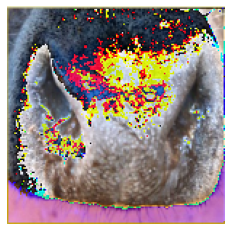

tensor([[ -2.5604, -25.0767, -27.1957, -21.7857, -18.6270, -26.8037, -19.9399,
         -25.0328, -22.3005, -20.2574, -17.1481, -21.8964, -22.0604, -17.8651,
         -20.4385, -20.9347, -24.8502, -21.0610, -22.6877, -20.0101, -19.1680,
         -21.8162, -17.4657, -19.9334, -14.6541, -25.2632, -21.9796, -23.1589,
         -25.2546, -20.4110, -17.7706, -26.9660, -27.0707, -26.8751, -26.1423,
         -25.0464, -20.4037, -23.2280, -22.5492, -26.2599, -19.5743, -17.9828,
         -19.7970, -26.8275, -29.4959, -22.5427, -19.3495, -20.9625, -22.5903,
         -22.6687, -21.2866, -22.7456, -23.6358, -17.0182, -20.3775, -24.9364,
         -22.5713, -22.0876, -21.3605, -30.1075, -17.1425, -18.7350, -23.8297,
         -25.6479, -15.8165, -17.8625, -20.1272, -24.4811, -22.5486, -28.4398,
         -23.1888, -24.4013, -19.8155, -23.8000, -24.0322, -26.7512, -26.7937,
         -27.4610, -23.5782, -23.0743, -28.5778, -20.0748, -21.5731, -18.0815,
         -22.0432, -20.5417, -29.7161, -28.3003, -27

In [15]:
from PIL import Image
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Load the input image
image_path = r"E:\g42\cattle_final_dataset\train\050\IMG_0355.JPG" # Replace with the path to your image
image = Image.open(image_path)

# Define the transformation
transform = transforms.Compose([
    transforms.Resize((150, 150)),  # Resize the image to match the input size used during training
    transforms.ToTensor(),           # Convert to a PyTorch tensor
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # Normalize pixel values
])

# Apply the transformation to the image
input_image = transform(image).unsqueeze(0)  # Add a batch dimension

# Print the input image
plt.imshow(transforms.ToPILImage()(input_image.squeeze(0)))  # Convert the tensor back to an image
plt.axis('off')  # Hide axis labels
plt.show()

# Make a prediction
with torch.no_grad():
    output = model(input_image)
    
    
print(output)
print(torch.max(output))

# Get the predicted class index
_, predicted_class = torch.max(output, 1)
confidence = torch.softmax(output, 1)[0][predicted_class.item()] * 100

# Map the class index to the actual class name (if you have a list of class names)
predicted_class_name = classes[predicted_class.item()]

# print(f"The predicted class is: {predicted_class_name}")

# print(f"Confidence: {confidence:.2f}%")

# Define a confidence threshold (adjust this value as needed)
confidence_threshold = 98  # Example threshold value
print(len(classes),len(output[0]))

# Check if the confidence score is below the threshold
if confidence < confidence_threshold:
    print("The image is not registered.")
else:
    print(f"The predicted class is: {predicted_class_name}")
    print(f"Confidence: {confidence:.2f}%")

In [3]:
# to rename 150_muzzle with 150

import os

# Path to the directory containing the folders
folder_path = r"E:\g42\frontend\static\train"

for folder_name in os.listdir(folder_path):
    if '_muzzle' in folder_name:
        old_path = os.path.join(folder_path, folder_name)
        new_path = os.path.join(folder_path, folder_name.replace('_muzzle', ''))
        os.rename(old_path, new_path)


In [ ]:
# #CNN Network


# class ConvNet(nn.Module):
#     def __init__(self,num_classes=6):
#         super(ConvNet,self).__init__()
        
#         #Output size after convolution filter
#         #((w-f+2P)/s) +1
        
#         #Input shape= (256,3,150,150)
        
#         self.conv1=nn.Conv2d(in_channels=3,out_channels=12,kernel_size=3,stride=1,padding=1)
#         #Shape= (256,12,150,150)
#         self.bn1=nn.BatchNorm2d(num_features=12)
#         #Shape= (256,12,150,150)
#         self.relu1=nn.ReLU()
#         #Shape= (256,12,150,150)
        
#         self.pool=nn.MaxPool2d(kernel_size=2)
#         #Reduce the image size be factor 2
#         #Shape= (256,12,75,75)
        
        
#         self.conv2=nn.Conv2d(in_channels=12,out_channels=20,kernel_size=3,stride=1,padding=1)
#         #Shape= (256,20,75,75)
#         self.relu2=nn.ReLU()
#         #Shape= (256,20,75,75)
        
        
        
#         self.conv3=nn.Conv2d(in_channels=20,out_channels=32,kernel_size=3,stride=1,padding=1)
#         #Shape= (256,32,75,75)
#         self.bn3=nn.BatchNorm2d(num_features=32)
#         #Shape= (256,32,75,75)
#         self.relu3=nn.ReLU()
#         #Shape= (256,32,75,75)
        
        
#         self.fc=nn.Linear(in_features=75 * 75 * 32,out_features=num_classes)
        
        
        
#         #Feed forwad function
        
#     def forward(self,input):
#         output=self.conv1(input)
#         output=self.bn1(output)
#         output=self.relu1(output)
            
#         output=self.pool(output)
            
#         output=self.conv2(output)
#         output=self.relu2(output)
            
#         output=self.conv3(output)
#         output=self.bn3(output)
#         output=self.relu3(output)
            
            
#             #Above output will be in matrix form, with shape (256,32,75,75)
            
#         output=output.view(-1,32*75*75)
            
            
#         output=self.fc(output)
            
#         return output
       

# #Transforms
# transformer=transforms.Compose([
#     transforms.Resize((150,150)),
#     transforms.RandomHorizontalFlip(),
#     transforms.ToTensor(),  #0-255 to 0-1, numpy to tensors
#     transforms.Normalize([0.5,0.5,0.5], # 0-1 to [-1,1] , formula (x-mean)/std
#                         [0.5,0.5,0.5])
# ])

In [ ]:
# #categories
# dataset_path = r"E:\g42\cattle_final_dataset"
# root=pathlib.Path(os.path.join(dataset_path,'train'))
# classes=sorted([j.name.split('/')[-1] for j in root.iterdir()])

In [ ]:
# print(classes)

# print("")

# print("len",len(classes))

In [ ]:
# import torch

# # Create an instance of your model
# model = ConvNet(num_classes=len(classes))  # Replace with your actual model class and configuration

# # Load the saved model weights
# model.load_state_dict(torch.load('cattle_aadhar_copy.model'))

# # Set the model in evaluation mode (important if you're using dropout or batch normalization)
# model.eval()

# # import torch

# # # Create an instance of your model
# # model = ConvNet(num_classes=len(classes))  # Replace with your actual model class and configuration

# # # Load the saved model weights
# # model.load_state_dict(torch.load('cattle_aadhar_100epochs.model'))

# # # Set the model in evaluation mode (important if you're using dropout or batch normalization)
# # model.eval()

In [ ]:
# import torch
# import torch.nn as nn
# import torchvision
# from torchvision import transforms
# from torch.utils.data import DataLoader, Dataset
# import os


# # Load your existing ConvNet model (assuming you have trained it)
# model = ConvNet(num_classes=classes)  # Instantiate your model or load the pretrained weights

# # Freeze feature extraction layers (if they are named 'features')
# for param in model.features.parameters():
#     param.requires_grad = False

# # Define a new classification layer for class 151
# num_classes = len(classes)+1  # Including the new class
# in_features = model.fc.in_features  # Get the number of in_features for the classification layer
# model.fc = nn.Linear(in_features, num_classes)  # Replace the classification layer

# # Define a custom dataset class for class 151
# class CustomDataset(Dataset):
#     def __init__(self, data_dir, transform=None):
#         self.data = torchvision.datasets.ImageFolder(data_dir, transform=transform)

#     def __len__(self):
#         return len(self.data)

#     def __getitem__(self, idx):
#         return self.data[idx]

# # Create a DataLoader for the new class (class 151)
# new_class_dataset = CustomDataset(data_dir=dataset_path, transform=transforms.Compose([
#     transforms.Resize((150, 150)),
#     transforms.ToTensor(),
#     transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
# ]))

# new_class_loader = DataLoader(new_class_dataset, batch_size=32, shuffle=True)

# # Define loss and optimizer
# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.fc.parameters(), lr=0.001)

# # Train the model on the new class
# num_epochs = 10
# for epoch in range(num_epochs):
#     model.train()
#     for images, labels in new_class_loader:
#         optimizer.zero_grad()
#         outputs = model(images)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()
#     print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item()}')

# # Save the updated model
# torch.save(model.state_dict(), 'incremental_model.pth')


In [ ]:
# i=0

In [ ]:
# print(classes)

In [ ]:
# #Transforms
# transformer=transforms.Compose([
#     transforms.Resize((150,150)),
#     transforms.RandomHorizontalFlip(),
#     transforms.CenterCrop(150),
#     transforms.ToTensor(),  #0-255 to 0-1, numpy to tensors
#     transforms.Normalize([0.5,0.5,0.5], # 0-1 to [-1,1] , formula (x-mean)/std
#                         [0.5,0.5,0.5])
# ])